In [1]:
# Copyright 2019 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
import ipywidgets as wd
from scipy.stats import gaussian_kde as GKDE
from math import *
from luq import *

plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.linewidth': 2})

np.random.seed(123456)

The model is the Sel'kov model for glycolysis, a process by which living cells breakdown sugar to obtain energy:
$$x' = -(x+b) + a \left(y + \frac{b}{a+b^2} \right) + (x+b)^2 \left(y + \frac{b}{a+b^2}\right)$$
$$y' = b-a\left(y+ \frac{b}{a+b^2}\right) - (x+b)^2 \left(y + \frac{b}{a+b^2}\right), $$
where $x$ and $y$ represent concentrations of ADP and F6P, respectively, and $a,b>0$.
The initial conditions are $x(0) = x_0 \in \mathbb{R}$ and $y(0) = y_0 \in \mathbb{R}$.

The system has Hopf Bifurcations at 
$$b = b_1(a) = \sqrt{(1-\sqrt{1-8a}-2a)/2}$$
and
$$b = b_2(a) = \sqrt{(1+\sqrt{1-8a}-2a)/2}.$$
If $b<b_1$, the origin is a stable focus. If $b_1 < b < b_2$, there is a stable periodic orbit.
If $b > b_2$ the origin is a stable focus.

The system is solved numerically using the RK45 method.

A ***true*** distribution of $a, b,  x_0$, and $y_0$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [2]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(1E3)

param_range = np.array([[0.01, 0.124], # a
                       [0.05, 1.5]])  #b
ic_range = np.array([[1.0, 1.0],  # y_0
                     [1.0, 1.0]])  # x_0

params = np.random.uniform(size=(num_samples, 2))
params = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params

ics = np.random.uniform(size=(num_samples, 2))
ics = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics

# labels
param_labels = [r'$a$', r'$b$']
ic_labels = [r'$x_0$', r'$y_0$']

# Construct the predicted time series data
num_time_preds = int(1000)  # number of predictions (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 40.0
times = np.linspace(time_start, time_end, num_time_preds)

# Solve systems
phys = ds.Selkov()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)

In [3]:
# Simulate an observed Beta distribution of time series data

num_obs = int(1E3)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
params_obs = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params_obs

ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
ics_obs = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics_obs

# Solve system
observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)

# Add noise if desired
with_noise = True
noise_stdev = 0.0125

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs)

In [4]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 40
time_end_idx = 150 #120

# Clean data
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=20, tol=5.0e-2, min_knots=3, max_knots=8)

0 4 0.15606448070488063
0 5 0.07149149119022374
0 6 0.06218452425030992
0 6 knots being used with error of 0.06218452425030992
1 4 0.14889839540413505
1 5 0.06610254133455287
1 6 0.0426826590538955
1 6 knots being used with error of 0.0426826590538955
2 4 0.03007877014089001
2 5 0.01649348008413395
2 5 knots being used with error of 0.01649348008413395
3 4 0.14793163543793258
3 5 0.06336335802793158
3 6 0.039596889881949364
3 7 0.03364601224643426
3 7 knots being used with error of 0.03364601224643426
4 4 0.021394592339253855
4 5 0.012179390170329462
4 5 knots being used with error of 0.012179390170329462
5 4 0.02562123310049312
5 5 0.014560118349624467
5 5 knots being used with error of 0.014560118349624467
6 4 0.14677350795500965
6 5 0.06361276735455534
6 6 0.040172340570601345
6 7 0.03346350027437842
6 7 knots being used with error of 0.03346350027437842
7 4 0.03540356277992689
7 5 0.01936884242415676
7 5 knots being used with error of 0.01936884242415676
8 4 0.08330947094486695
8 5

68 4 0.05616706850806943
68 5 0.03135256553878915
68 6 0.020607969631195315
68 6 knots being used with error of 0.020607969631195315
69 4 0.03520476421926941
69 5 0.020349159290179133
69 5 knots being used with error of 0.020349159290179133
70 4 0.056058710492005635
70 5 0.031412030480943993
70 6 0.020270977368143227
70 6 knots being used with error of 0.020270977368143227
71 4 0.02920012762541989
71 5 0.016858828422235517
71 5 knots being used with error of 0.016858828422235517
72 4 0.07688014174801759
72 5 0.04306664603600755
72 6 0.027703663621797527
72 6 knots being used with error of 0.027703663621797527
73 4 0.0773609768932377
73 5 0.05218707193892435
73 6 0.03694770781479846
73 6 knots being used with error of 0.03694770781479846
74 4 0.15338998850530966
74 5 0.06802918079454065
74 6 0.060400473892422826
74 6 knots being used with error of 0.060400473892422826
75 4 0.07593162816458174
75 5 0.06576470707079883
75 5 knots being used with error of 0.06576470707079883
76 4 0.1621356

135 4 0.05342317060696576
135 5 0.03003925375997235
135 6 0.019437013089453493
135 6 knots being used with error of 0.019437013089453493
136 4 0.029707101948116613
136 5 0.017020959794637684
136 5 knots being used with error of 0.017020959794637684
137 4 0.1547878075231991
137 5 0.06957508806141412
137 6 0.06103569126290884
137 6 knots being used with error of 0.06103569126290884
138 4 0.030184306220553285
138 5 0.017448074540038657
138 5 knots being used with error of 0.017448074540038657
139 4 0.043362423242160476
139 5 0.024554593037019415
139 5 knots being used with error of 0.024554593037019415
140 4 0.08156879874995338
140 5 0.045539845554855754
140 6 0.028764356569704014
140 6 knots being used with error of 0.028764356569704014
141 4 0.04727696131306015
141 5 0.02693772199479307
141 6 0.017431851370185013
141 6 knots being used with error of 0.017431851370185013
142 4 0.10758705349154703
142 5 0.06277058675852859
142 6 0.038308982367845384
142 7 0.033621645771514434
142 7 knots 

201 5 0.015547665089831157
201 5 knots being used with error of 0.015547665089831157
202 4 0.04567036867484336
202 5 0.025735512834455097
202 6 0.017147568336346408
202 6 knots being used with error of 0.017147568336346408
203 4 0.033770797157518524
203 5 0.019090515436326356
203 5 knots being used with error of 0.019090515436326356
204 4 0.07305989279044023
204 5 0.04122046456990934
204 6 0.02638351935234432
204 6 knots being used with error of 0.02638351935234432
205 4 0.15362203167791363
205 5 0.06765263355726733
205 6 0.060243544346916963
205 6 knots being used with error of 0.060243544346916963
206 4 0.15362984967417062
206 5 0.06876602305388287
206 6 0.060883009346576346
206 6 knots being used with error of 0.060883009346576346
207 4 0.03505028618161711
207 5 0.019314314103808315
207 5 knots being used with error of 0.019314314103808315
208 4 0.038523020886060376
208 5 0.020979509092415322
208 5 knots being used with error of 0.020979509092415322
209 4 0.15893588878655515
209 5 0

266 5 0.019480951807229818
266 5 knots being used with error of 0.019480951807229818
267 4 0.02817568081857008
267 5 0.015476152237355427
267 5 knots being used with error of 0.015476152237355427
268 4 0.03422568400250556
268 5 0.01995116714549825
268 5 knots being used with error of 0.01995116714549825
269 4 0.14997654266670551
269 5 0.06548020256311228
269 6 0.04184400746735123
269 6 knots being used with error of 0.04184400746735123
270 4 0.07944701128827371
270 5 0.04255478671235983
270 6 0.026943864908363653
270 6 knots being used with error of 0.026943864908363653
271 4 0.05308570866071616
271 5 0.0297889621958727
271 6 0.01948125204223882
271 6 knots being used with error of 0.01948125204223882
272 4 0.15033636247986593
272 5 0.06408527856470848
272 6 0.04023797114621078
272 7 0.03400685844691677
272 7 knots being used with error of 0.03400685844691677
273 4 0.04922673276086511
273 5 0.027724525828660095
273 6 0.018025377146356703
273 6 knots being used with error of 0.018025377

333 4 0.07135356278448973
333 5 0.04027063095030778
333 6 0.02584047020661236
333 6 knots being used with error of 0.02584047020661236
334 4 0.07492096474795279
334 5 0.0460555322110997
334 6 0.03784243205663582
334 6 knots being used with error of 0.03784243205663582
335 4 0.030572969947511335
335 5 0.017905573796401664
335 5 knots being used with error of 0.017905573796401664
336 4 0.0500504623294897
336 5 0.027803811712646915
336 6 0.018241781784531237
336 6 knots being used with error of 0.018241781784531237
337 4 0.07551997469038482
337 5 0.04258142704160526
337 6 0.027162341760842083
337 6 knots being used with error of 0.027162341760842083
338 4 0.03985229264045141
338 5 0.022843828308708902
338 5 knots being used with error of 0.022843828308708902
339 4 0.045728150340303225
339 5 0.025178189397865685
339 6 0.01637021067319985
339 6 knots being used with error of 0.01637021067319985
340 4 0.04796832094146878
340 5 0.026937230793628652
340 6 0.017601865536600477
340 6 knots being

400 4 0.0544970258543599
400 5 0.03067390812129579
400 6 0.019841283025701296
400 6 knots being used with error of 0.019841283025701296
401 4 0.05912469497263607
401 5 0.0335330716330725
401 6 0.02152797501281988
401 6 knots being used with error of 0.02152797501281988
402 4 0.1482621639457395
402 5 0.06308015033281804
402 6 0.03935678076938672
402 7 0.03355804825415013
402 7 knots being used with error of 0.03355804825415013
403 4 0.09909982994320607
403 5 0.062428094014582436
403 6 0.03775749352404288
403 7 0.026738564006363093
403 7 knots being used with error of 0.026738564006363093
404 4 0.15906268768689172
404 5 0.0717097897898457
404 6 0.06318263413548077
404 6 knots being used with error of 0.06318263413548077
405 4 0.15368867505465802
405 5 0.06705073110206722
405 6 0.06014836305753301
405 6 knots being used with error of 0.06014836305753301
406 4 0.05093424226587803
406 5 0.028640841433181692
406 6 0.01873383045550594
406 6 knots being used with error of 0.01873383045550594
4

466 7 0.03383469230818407
466 7 knots being used with error of 0.03383469230818407
467 4 0.03663889991646857
467 5 0.020875469987889608
467 5 knots being used with error of 0.020875469987889608
468 4 0.07364548347988117
468 5 0.04205187970063081
468 6 0.02904624346098725
468 6 knots being used with error of 0.02904624346098725
469 4 0.15060569687655337
469 5 0.06287229266600097
469 6 0.038602130661418814
469 7 0.033783005334695346
469 7 knots being used with error of 0.033783005334695346
470 4 0.043693527445349586
470 5 0.024482837771471897
470 5 knots being used with error of 0.024482837771471897
471 4 0.1582335699143028
471 5 0.07153453507224111
471 6 0.06283875177219816
471 6 knots being used with error of 0.06283875177219816
472 4 0.030782822670210427
472 5 0.017576587139752388
472 5 knots being used with error of 0.017576587139752388
473 4 0.02499418696429846
473 5 0.01396818694881106
473 5 knots being used with error of 0.01396818694881106
474 4 0.0531544992572762
474 5 0.0296663

532 4 0.15329538151385502
532 5 0.06773949675464044
532 6 0.06012020088077805
532 6 knots being used with error of 0.06012020088077805
533 4 0.03378360236149367
533 5 0.018860587477712104
533 5 knots being used with error of 0.018860587477712104
534 4 0.054313867789143634
534 5 0.030529333582471396
534 6 0.019715269850478077
534 6 knots being used with error of 0.019715269850478077
535 4 0.07262715228785366
535 5 0.04247734878547565
535 6 0.03027364310958594
535 6 knots being used with error of 0.03027364310958594
536 4 0.07543606646595168
536 5 0.049249007579179715
536 6 0.03666824612057393
536 6 knots being used with error of 0.03666824612057393
537 4 0.056888070671418926
537 5 0.03223499622716411
537 6 0.02097743468875386
537 6 knots being used with error of 0.02097743468875386
538 4 0.051997338819242074
538 5 0.029483886650914882
538 6 0.01893939389960443
538 6 knots being used with error of 0.01893939389960443
539 4 0.15310429695783098
539 5 0.06794192012183796
539 6 0.06026306880

596 5 0.021113640113902873
596 5 knots being used with error of 0.021113640113902873
597 4 0.028673425807115932
597 5 0.016537688091864493
597 5 knots being used with error of 0.016537688091864493
598 4 0.03579484049516906
598 5 0.020503081316385435
598 5 knots being used with error of 0.020503081316385435
599 4 0.032489106914517264
599 5 0.0185723839021082
599 5 knots being used with error of 0.0185723839021082
600 4 0.05271237003855216
600 5 0.029578269387964425
600 6 0.019334010624457398
600 6 knots being used with error of 0.019334010624457398
601 4 0.03894142372214968
601 5 0.020984911908427124
601 5 knots being used with error of 0.020984911908427124
602 4 0.05480087603408498
602 5 0.030649946467050573
602 6 0.019821129470409243
602 6 knots being used with error of 0.019821129470409243
603 4 0.15808614744060387
603 5 0.07227805831428724
603 6 0.06308659635795834
603 6 knots being used with error of 0.06308659635795834
604 4 0.03286671155416228
604 5 0.019131828217097087
604 5 kno

663 5 0.013609322634554274
663 5 knots being used with error of 0.013609322634554274
664 4 0.0787239732147331
664 5 0.044304326661418945
664 6 0.02813594375412676
664 6 knots being used with error of 0.02813594375412676
665 4 0.07242368021494273
665 5 0.041556181554440234
665 6 0.028694189991075834
665 6 knots being used with error of 0.028694189991075834
666 4 0.05112956048482734
666 5 0.028922771319519727
666 6 0.018742226615437712
666 6 knots being used with error of 0.018742226615437712
667 4 0.0566030024223495
667 5 0.031614340306629865
667 6 0.020765765698800325
667 6 knots being used with error of 0.020765765698800325
668 4 0.0891100897484527
668 5 0.06312592828199397
668 6 0.036656614767087446
668 7 0.025689824071094446
668 7 knots being used with error of 0.025689824071094446
669 4 0.04250056774038679
669 5 0.02441235010902844
669 6 0.01593534523598697
669 6 knots being used with error of 0.01593534523598697
670 4 0.032840222791378035
670 5 0.0189733166111387
670 5 knots being

730 4 0.05339028470931815
730 5 0.029977262431866263
730 6 0.01964034836160514
730 6 knots being used with error of 0.01964034836160514
731 4 0.031957760615397554
731 5 0.017886495821536213
731 5 knots being used with error of 0.017886495821536213
732 4 0.05642342551120605
732 5 0.031559037492718996
732 6 0.020645654557334855
732 6 knots being used with error of 0.020645654557334855
733 4 0.09388130756350067
733 5 0.06267968665419614
733 6 0.037205502753699125
733 7 0.02631892240439941
733 7 knots being used with error of 0.02631892240439941
734 4 0.158668368631619
734 5 0.0717546510795054
734 6 0.0630594869510721
734 6 knots being used with error of 0.0630594869510721
735 4 0.025138334893661674
735 5 0.014416964519533846
735 5 knots being used with error of 0.014416964519533846
736 4 0.1621388890496282
736 5 0.0726814569149192
736 6 0.06376714953430516
736 6 knots being used with error of 0.06376714953430516
737 4 0.15526653688725753
737 5 0.06881305815154348
737 6 0.06070068744847529

794 4 0.035164949598131476
794 5 0.020272745801042758
794 5 knots being used with error of 0.020272745801042758
795 4 0.041080276715421325
795 5 0.02290855686981081
795 5 knots being used with error of 0.02290855686981081
796 4 0.039479099160516104
796 5 0.02210121145096509
796 5 knots being used with error of 0.02210121145096509
797 4 0.04490406550713437
797 5 0.025215091190801207
797 6 0.016751130813435468
797 6 knots being used with error of 0.016751130813435468
798 4 0.08318495341624367
798 5 0.045364622426540685
798 6 0.028347645558353597
798 6 knots being used with error of 0.028347645558353597
799 4 0.0816016792021724
799 5 0.04498196808943362
799 6 0.028250876971418985
799 6 knots being used with error of 0.028250876971418985
800 4 0.07847091291640791
800 5 0.06479495230305961
800 5 knots being used with error of 0.06479495230305961
801 4 0.07418205445722247
801 5 0.04374785164387662
801 6 0.0315287304711308
801 6 knots being used with error of 0.0315287304711308
802 4 0.027265

861 4 0.04243412265360543
861 5 0.023682808783279066
861 5 knots being used with error of 0.023682808783279066
862 4 0.04880409932041191
862 5 0.02764059961523022
862 6 0.01811134432073787
862 6 knots being used with error of 0.01811134432073787
863 4 0.03728885009164104
863 5 0.021097305965775952
863 5 knots being used with error of 0.021097305965775952
864 4 0.09919161496552195
864 5 0.06261731686602737
864 6 0.03782046118004423
864 7 0.026904290146702797
864 7 knots being used with error of 0.026904290146702797
865 4 0.028294515699007074
865 5 0.01607366704859085
865 5 knots being used with error of 0.01607366704859085
866 4 0.08818959829780325
866 5 0.06327123053573276
866 6 0.03641739165633799
866 7 0.025752847665281763
866 7 knots being used with error of 0.025752847665281763
867 4 0.15914078499042375
867 5 0.07181996736842605
867 6 0.06291836583733686
867 6 knots being used with error of 0.06291836583733686
868 4 0.06699078872298991
868 5 0.03783726226030541
868 6 0.024429819952

925 5 0.06937824025310799
925 6 0.061614329635340546
925 6 knots being used with error of 0.061614329635340546
926 4 0.03391608851775149
926 5 0.018969915083979726
926 5 knots being used with error of 0.018969915083979726
927 4 0.15285288501527067
927 5 0.06716622826344237
927 6 0.2888234887701718
927 7 0.03514933220638691
927 8 0.025509678275034666
927 8 knots being used with error of 0.025509678275034666
928 4 0.056306597870416586
928 5 0.03147492379416619
928 6 0.020646592967635134
928 6 knots being used with error of 0.020646592967635134
929 4 0.023151645677578655
929 5 0.0129828268717139
929 5 knots being used with error of 0.0129828268717139
930 4 0.05598157574730591
930 5 0.03132340934688063
930 6 0.020597592177762202
930 6 knots being used with error of 0.020597592177762202
931 4 0.09953877227704447
931 5 0.06264019184390555
931 6 0.03760179866388209
931 7 0.02682195528994525
931 7 knots being used with error of 0.02682195528994525
932 4 0.026169099022994104
932 5 0.01477325770

990 6 0.01985844197374847
990 6 knots being used with error of 0.01985844197374847
991 4 0.15613953179014506
991 5 0.07018605922844313
991 6 0.06168119261062659
991 6 knots being used with error of 0.06168119261062659
992 4 0.05493781675472997
992 5 0.030646411991124667
992 6 0.020130961739338565
992 6 knots being used with error of 0.020130961739338565
993 4 0.07305847960419556
993 5 0.04615371874157933
993 6 0.03670328718532563
993 6 knots being used with error of 0.03670328718532563
994 4 0.021179180862471933
994 5 0.01201659934883359
994 5 knots being used with error of 0.01201659934883359
995 4 0.058948396962014676
995 5 0.03360725416722349
995 6 0.021579716281634468
995 6 knots being used with error of 0.021579716281634468
996 4 0.03098982123047562
996 5 0.017427843579495044
996 5 knots being used with error of 0.017427843579495044
997 4 0.030167723173081952
997 5 0.016930549801560224
997 5 knots being used with error of 0.016930549801560224
998 4 0.0825080435960914
998 5 0.04583

58 5 0.05926423487192104
58 5 knots being used with error of 0.05926423487192104
59 4 0.12931737090003995
59 5 0.11248086210775443
59 6 0.1048303860247477
59 6 knots being used with error of 0.1048303860247477
60 4 0.1671720617231608
60 5 0.14920223815182693
60 6 0.14752460512367377
60 7 0.13832955085666665
60 7 knots being used with error of 0.13832955085666665
61 4 0.13905755474018805
61 5 0.12390855811276102
61 6 0.11341559370153945
61 7 0.10730479074813487
61 7 knots being used with error of 0.10730479074813487
62 4 0.043166616237445166
62 5 0.038942514626464586
62 5 knots being used with error of 0.038942514626464586
63 4 0.21300070549881994
63 5 0.17678338382046144
63 6 0.1755938543850815
63 6 knots being used with error of 0.1755938543850815
64 4 0.05289561697286674
64 5 0.04654753139410213
64 5 knots being used with error of 0.04654753139410213
65 4 0.06410126714310135
65 5 0.05657532413049007
65 5 knots being used with error of 0.05657532413049007
66 4 0.09727664879515123
66 5

125 5 0.07329846562966157
125 5 knots being used with error of 0.07329846562966157
126 4 0.05025533920898681
126 5 0.045503555813524214
126 5 knots being used with error of 0.045503555813524214
127 4 0.05300361043139338
127 5 0.046167360844374686
127 5 knots being used with error of 0.046167360844374686
128 4 0.03872308451912689
128 5 0.03559756601993371
128 5 knots being used with error of 0.03559756601993371
129 4 0.037574201246605786
129 5 0.0346297565966347
129 5 knots being used with error of 0.0346297565966347
130 4 0.050298341647199485
130 5 0.044983586993102294
130 5 knots being used with error of 0.044983586993102294
131 4 0.06906919175933819
131 5 0.05787530271355695
131 5 knots being used with error of 0.05787530271355695
132 4 0.06481224836764059
132 5 0.05738555447375093
132 5 knots being used with error of 0.05738555447375093
133 4 0.09698665244366783
133 5 0.08095452317591754
133 5 knots being used with error of 0.08095452317591754
134 4 0.05592889214554551
134 5 0.04834

193 4 0.09866057417576697
193 5 0.0913400460189755
193 6 0.08162475520732201
193 6 knots being used with error of 0.08162475520732201
194 4 0.07494244726889242
194 5 0.061532564186850665
194 5 knots being used with error of 0.061532564186850665
195 4 0.0758753570214827
195 5 0.06091847988078891
195 5 knots being used with error of 0.06091847988078891
196 4 0.04983690054765834
196 5 0.04321375721032732
196 5 knots being used with error of 0.04321375721032732
197 4 0.0885755957580013
197 5 0.07675255656933057
197 6 0.06464594738738254
197 6 knots being used with error of 0.06464594738738254
198 4 0.15768257882945036
198 5 0.1408323424015744
198 6 0.1365425375314257
198 7 0.12603477775442382
198 7 knots being used with error of 0.12603477775442382
199 4 0.04875047119852869
199 5 0.04253153760415084
199 5 knots being used with error of 0.04253153760415084
200 4 0.054044013486701466
200 5 0.048606960115214454
200 5 knots being used with error of 0.048606960115214454
201 4 0.0494996709549222

260 5 0.10304361754744977
260 6 0.0949830790838458
260 6 knots being used with error of 0.0949830790838458
261 4 0.06491967514827478
261 5 0.05740457491414798
261 5 knots being used with error of 0.05740457491414798
262 4 0.21855712765744306
262 5 0.18253523188640836
262 6 0.18249032250174554
262 6 knots being used with error of 0.18249032250174554
263 4 0.07731578192746706
263 5 0.06941084746431636
263 5 knots being used with error of 0.06941084746431636
264 4 0.04404703826663748
264 5 0.03945504991820341
264 5 knots being used with error of 0.03945504991820341
265 4 0.05185558577170134
265 5 0.04745705897363595
265 5 knots being used with error of 0.04745705897363595
266 4 0.09640323856548023
266 5 0.08453960480872613
266 6 0.07504036120027702
266 6 knots being used with error of 0.07504036120027702
267 4 0.2133896902671884
267 5 0.17629999191296702
267 6 0.17596031273509133
267 6 knots being used with error of 0.17596031273509133
268 4 0.03427016100221578
268 4 knots being used with

327 4 0.044803409500807766
327 5 0.04045323088154127
327 5 knots being used with error of 0.04045323088154127
328 4 0.07386399140145172
328 5 0.06001875150829363
328 5 knots being used with error of 0.06001875150829363
329 4 0.06209355471051736
329 5 0.05456924804905109
329 5 knots being used with error of 0.05456924804905109
330 4 0.13728472596909458
330 5 0.1249343237555016
330 6 0.11088795083664442
330 7 0.10234495197660255
330 7 knots being used with error of 0.10234495197660255
331 4 0.05430456016278544
331 5 0.048732886791330664
331 5 knots being used with error of 0.048732886791330664
332 4 0.09530864656308187
332 5 0.07699295963023421
332 6 0.06717254740221909
332 7 0.06679753799090653
332 7 knots being used with error of 0.06679753799090653
333 4 0.05239415290584059
333 5 0.04543965737128058
333 5 knots being used with error of 0.04543965737128058
334 4 0.1560488793725013
334 5 0.1410860864865834
334 6 0.13665458857178236
334 7 0.1260492342030044
334 7 knots being used with er

393 5 0.06446057006953516
393 5 knots being used with error of 0.06446057006953516
394 4 0.05219566295646496
394 5 0.0527791641392426
394 5 knots being used with error of 0.0527791641392426
395 4 0.036194406207755526
395 5 0.033418580241905096
395 5 knots being used with error of 0.033418580241905096
396 4 0.05799832287081332
396 5 0.051371380334075414
396 5 knots being used with error of 0.051371380334075414
397 4 0.08129465751066162
397 5 0.06714344064986942
397 6 0.05023907189997717
397 7 0.04993413370216955
397 7 knots being used with error of 0.04993413370216955
398 4 0.05041267357843023
398 5 0.04441836889861124
398 5 knots being used with error of 0.04441836889861124
399 4 0.11980273990806481
399 5 0.10372775393107331
399 6 0.09757951698327616
399 6 knots being used with error of 0.09757951698327616
400 4 0.26923294132352177
400 5 0.22934221322360207
400 6 0.228112809198439
400 6 knots being used with error of 0.228112809198439
401 4 0.04404759759527034
401 5 0.03923394576843332

461 5 0.07372434155184553
461 6 0.07384752620426788
461 6 knots being used with error of 0.07384752620426788
462 4 0.09576677256573884
462 5 0.07970172280905528
462 6 0.06839516735558099
462 7 0.06759901149295329
462 7 knots being used with error of 0.06759901149295329
463 4 0.09459598562016074
463 5 0.077803339901834
463 6 0.0647269140171569
463 7 0.06322176646248764
463 7 knots being used with error of 0.06322176646248764
464 4 0.04752546755119745
464 5 0.04263789444769048
464 5 knots being used with error of 0.04263789444769048
465 4 0.2487844462905526
465 5 0.2088747361177822
465 6 0.20230233108493198
465 6 knots being used with error of 0.20230233108493198
466 4 0.04705419484777799
466 5 0.0425809924232362
466 5 knots being used with error of 0.0425809924232362
467 4 0.05709743939890699
467 5 0.051237264700238185
467 5 knots being used with error of 0.051237264700238185
468 4 0.042833979691194304
468 5 0.038107334645224075
468 5 knots being used with error of 0.038107334645224075


526 4 0.22188956109121283
526 5 0.18742293515723035
526 6 0.17666370698010606
526 6 knots being used with error of 0.17666370698010606
527 4 0.08630111737303317
527 5 0.07237822912864934
527 6 0.054332772365872875
527 7 0.05410943946142605
527 7 knots being used with error of 0.05410943946142605
528 4 0.10108637665121925
528 5 0.08842918912396946
528 6 0.08618273328907679
528 6 knots being used with error of 0.08618273328907679
529 4 0.05273629023229484
529 5 0.04750774491154843
529 5 knots being used with error of 0.04750774491154843
530 4 0.14213385181622168
530 5 0.1282313205051378
530 6 0.11443110482267461
530 7 0.1106181992332767
530 8 0.10035271622227737
531 4 0.06663120181969048
531 5 0.058655613858438926
531 5 knots being used with error of 0.058655613858438926
532 4 0.09435552759467264
532 5 0.08490597014772024
532 6 0.07886690577751451
532 6 knots being used with error of 0.07886690577751451
533 4 0.0695695351783598
533 5 0.05972140443981257
533 6 0.0453734551996956
533 6 kno

594 4 0.09635735373331
594 5 0.08155307896428393
594 6 0.0719014486090291
594 7 0.07159868450259768
594 7 knots being used with error of 0.07159868450259768
595 4 0.055010005943631285
595 5 0.04962343923818257
595 5 knots being used with error of 0.04962343923818257
596 4 0.039007883426406105
596 5 0.03546874850525393
596 5 knots being used with error of 0.03546874850525393
597 4 0.045622848940759214
597 5 0.040682203994764826
597 5 knots being used with error of 0.040682203994764826
598 4 0.053577530436442006
598 5 0.048583612747169
598 5 knots being used with error of 0.048583612747169
599 4 0.08505604838002034
599 5 0.07292549955787861
599 6 0.05728214755712619
599 7 0.057008437810521596
599 7 knots being used with error of 0.057008437810521596
600 4 0.10529261739531133
600 5 0.08667470050781585
600 6 0.08681918740270635
600 6 knots being used with error of 0.08681918740270635
601 4 0.04044038268581918
601 5 0.037010051267019124
601 5 knots being used with error of 0.037010051267019

662 6 0.09558002856145512
662 6 knots being used with error of 0.09558002856145512
663 4 0.0797027956238709
663 5 0.06868849144576483
663 6 0.052507996799531914
663 7 0.05032434522258476
663 7 knots being used with error of 0.05032434522258476
664 4 0.05120620425313159
664 5 0.046811288573006725
664 5 knots being used with error of 0.046811288573006725
665 4 0.05516881879296685
665 5 0.04864751936865649
665 5 knots being used with error of 0.04864751936865649
666 4 0.06081925279224918
666 5 0.05396752049652168
666 5 knots being used with error of 0.05396752049652168
667 4 0.07311914758220096
667 5 0.06378799159496155
667 5 knots being used with error of 0.06378799159496155
668 4 0.09127407621464685
668 5 0.07617643660631652
668 5 knots being used with error of 0.07617643660631652
669 4 0.051237206766244235
669 5 0.045956160205796785
669 5 knots being used with error of 0.045956160205796785
670 4 0.20657445855805595
670 5 0.167909697692693
670 6 0.1661544492803499
670 6 knots being used

730 4 0.07285441080566644
730 5 0.06483554197440504
730 5 knots being used with error of 0.06483554197440504
731 4 0.09969941218283174
731 5 0.08699094543417031
731 6 0.0848781505210324
731 6 knots being used with error of 0.0848781505210324
732 4 0.1327230331890912
732 5 0.11607561556430232
732 6 0.10687452705524253
732 6 knots being used with error of 0.10687452705524253
733 4 0.08100775348600782
733 5 0.06681217666401057
733 5 knots being used with error of 0.06681217666401057
734 4 0.07266270024719533
734 5 0.05902067872903898
734 5 knots being used with error of 0.05902067872903898
735 4 0.04842534534361374
735 5 0.04308397765597021
735 5 knots being used with error of 0.04308397765597021
736 4 0.08318148215151357
736 5 0.0674679015439492
736 5 knots being used with error of 0.0674679015439492
737 4 0.041296163415222374
737 5 0.03721271390028445
737 5 knots being used with error of 0.03721271390028445
738 4 0.043875819880446844
738 5 0.039098747843606306
738 5 knots being used wit

797 5 0.07934031764143672
797 5 knots being used with error of 0.07934031764143672
798 4 0.07079317451215698
798 5 0.06195743550327141
798 5 knots being used with error of 0.06195743550327141
799 4 0.04532442258121618
799 5 0.04106939888334528
799 5 knots being used with error of 0.04106939888334528
800 4 0.05328459923934247
800 5 0.047821326788449504
800 5 knots being used with error of 0.047821326788449504
801 4 0.059257483475963886
801 5 0.05343127555836652
801 5 knots being used with error of 0.05343127555836652
802 4 0.07469417608966647
802 5 0.06232731000024378
802 5 knots being used with error of 0.06232731000024378
803 4 0.056437476517807325
803 5 0.0466080634536064
803 5 knots being used with error of 0.0466080634536064
804 4 0.0462002016212667
804 5 0.0419117517912261
804 5 knots being used with error of 0.0419117517912261
805 4 0.057075749794842694
805 5 0.05000779727588932
805 5 knots being used with error of 0.05000779727588932
806 4 0.06672269570774107
806 5 0.05334222238

863 4 0.039101076940826165
863 5 0.035840043050964755
863 5 knots being used with error of 0.035840043050964755
864 4 0.04932522011532418
864 5 0.044439864006922555
864 5 knots being used with error of 0.044439864006922555
865 4 0.05074077241661975
865 5 0.045341984772379496
865 5 knots being used with error of 0.045341984772379496
866 4 0.2489779198665429
866 5 0.20893741415848724
866 6 0.20204840473186178
866 6 knots being used with error of 0.20204840473186178
867 4 0.04115780229659476
867 5 0.03762609704170995
867 5 knots being used with error of 0.03762609704170995
868 4 0.2749844880180555
868 5 0.2346316050582683
868 6 0.23084279349060446
868 6 knots being used with error of 0.23084279349060446
869 4 0.22806119490013013
869 5 0.19091457705842288
869 6 0.18225162312381998
869 7 0.17943911523746972
869 7 knots being used with error of 0.17943911523746972
870 4 0.057520717032896254
870 5 0.05196093786747205
870 5 knots being used with error of 0.05196093786747205
871 4 0.08916860502

932 5 0.05719155449485167
932 5 knots being used with error of 0.05719155449485167
933 4 0.09635817847581124
933 5 0.08445724080671074
933 6 0.07493422341518446
933 6 knots being used with error of 0.07493422341518446
934 4 0.09839196636141605
934 5 0.08945065704438786
934 6 0.08299035045710532
934 6 knots being used with error of 0.08299035045710532
935 4 0.054951832934685516
935 5 0.04836168557785195
935 5 knots being used with error of 0.04836168557785195
936 4 0.07985183667700416
936 5 0.06612242184940441
936 6 0.049438517369122394
936 7 0.04904608175745326
936 7 knots being used with error of 0.04904608175745326
937 4 0.16868888667687898
937 5 0.15001827922378716
937 6 0.14839072778896004
937 7 0.1389217887649221
937 7 knots being used with error of 0.1389217887649221
938 4 0.19952818974177894
938 5 0.15690799877516715
938 6 0.15228807689667975
938 6 knots being used with error of 0.15228807689667975
939 4 0.06264831154966606
939 5 0.0625946087217188
939 5 knots being used with er

998 7 0.11480912462573563
998 7 knots being used with error of 0.11480912462573563
999 4 0.09488023722644895
999 5 0.07759063130819682
999 6 0.0778832564704726
999 6 knots being used with error of 0.0778832564704726


(array([[ 0.15633684,  0.09379889,  0.03126094, ...,  0.02341093,
          0.02130416,  0.01919739],
        [ 0.1605491 ,  0.08885357,  0.01715805, ...,  0.04028383,
          0.04118422,  0.0420846 ],
        [ 0.34000751,  0.23207752,  0.12414754, ..., -0.392703  ,
         -0.39719274, -0.40168248],
        ...,
        [ 0.26738653,  0.1679614 ,  0.06853627, ..., -0.39144131,
         -0.38946515, -0.38748899],
        [ 0.18370175,  0.09675098,  0.0098002 , ..., -0.06749725,
          0.01844757,  0.10439239],
        [ 0.43766738,  0.32763833,  0.21760928, ..., -0.19104836,
         -0.19204734, -0.19304632]]),
 array([[ 0.31555342,  0.21529679,  0.11504016, ..., -0.35984581,
         -0.35908219, -0.35831856],
        [ 0.2871646 ,  0.19168329,  0.09620197, ..., -0.30672938,
         -0.30015367, -0.29357796],
        [ 0.177098  ,  0.09171819,  0.00633838, ...,  0.01207811,
          0.09852888,  0.18497965],
        ...,
        [ 0.23970625,  0.14627057,  0.05283489, ..., -

In [28]:
# Learn and classify dynamics
learn.dynamics(cluster_method='spectral', kwargs={'n_clusters': 3, 'n_init': 10})

0.016 misclassification rate for  {'kernel': 'linear'}
0.020999999999999998 misclassification rate for  {'kernel': 'rbf'}
0.621 misclassification rate for  {'kernel': 'poly'}
0.028000000000000004 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.016


Text(0.5, 1.0, 'Approximating Dynamics')

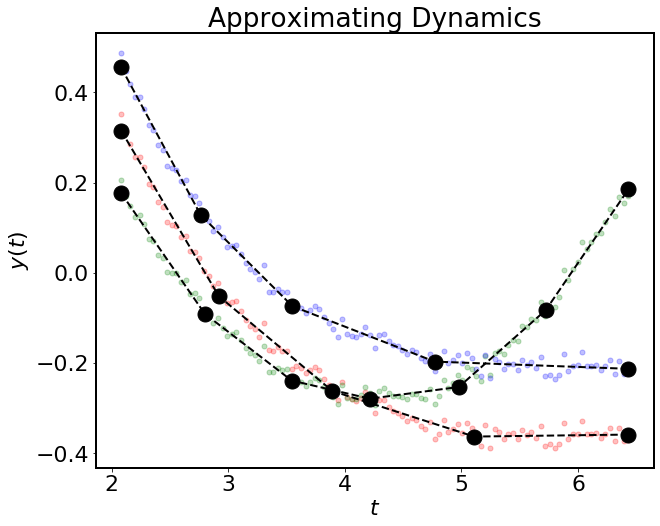

In [29]:
fig = plt.figure(figsize=(10,8))

# chosen_obs = [109, 8]

chosen_obs = [0, 2, 7]  #7]
colors = ['r', 'g', 'b']

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    num_i_knots = int(0.5*(2+len(learn.obs_knots[i])))
    knots = np.copy(learn.obs_knots[i][num_i_knots:])
    knots = np.insert(knots, 0, learn.clean_times[0])
    knots = np.append(knots, learn.clean_times[-1])
    plt.plot(knots, learn.obs_knots[i][:num_i_knots], 'k', linestyle='dashed', markersize=15, marker='o', linewidth=2)
    
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('Approximating Dynamics') 

Text(0.5, 1.0, 'Generating Clean Data')

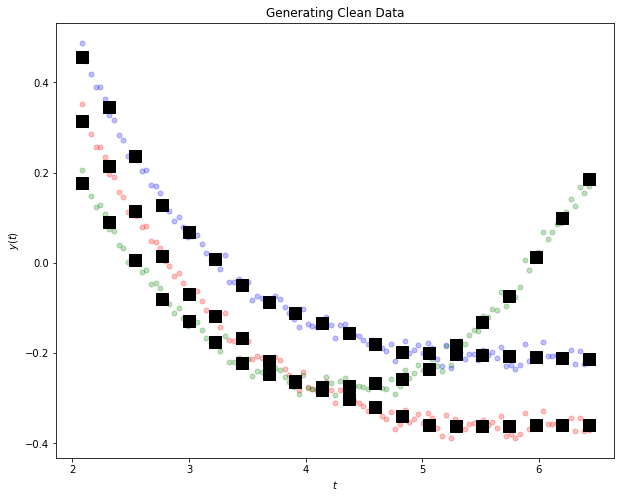

In [7]:
fig = plt.figure(figsize=(10,8))

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    plt.plot(learn.clean_times, learn.clean_obs[i,:],'k', linestyle='none', marker='s', 
            markersize=12)
    
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('Generating Clean Data') 

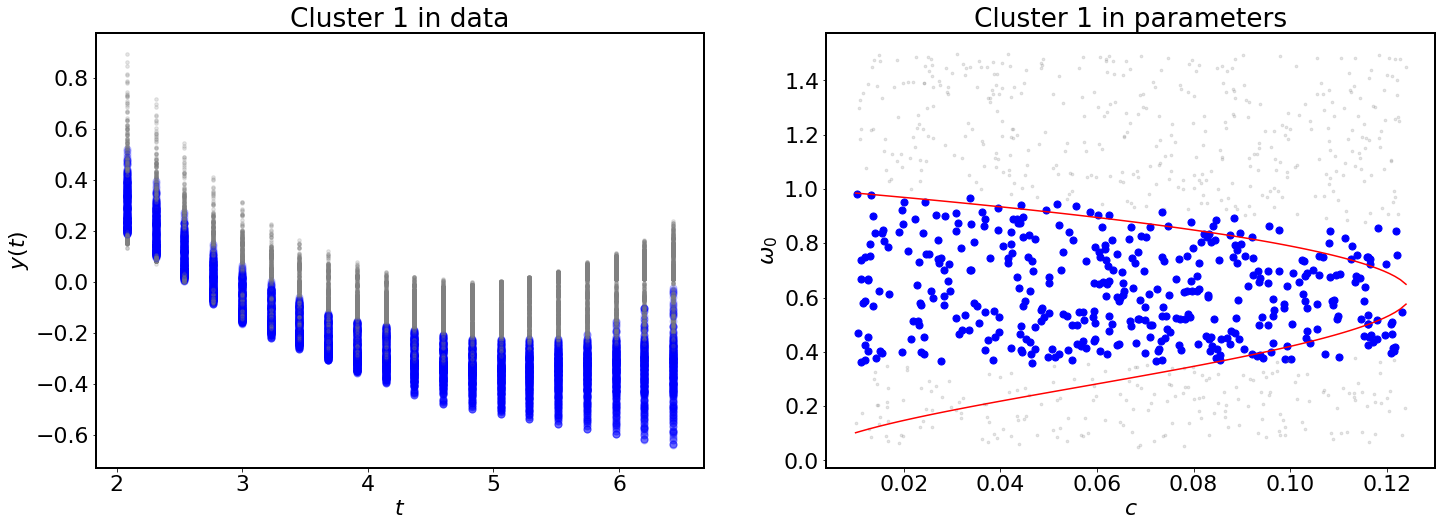

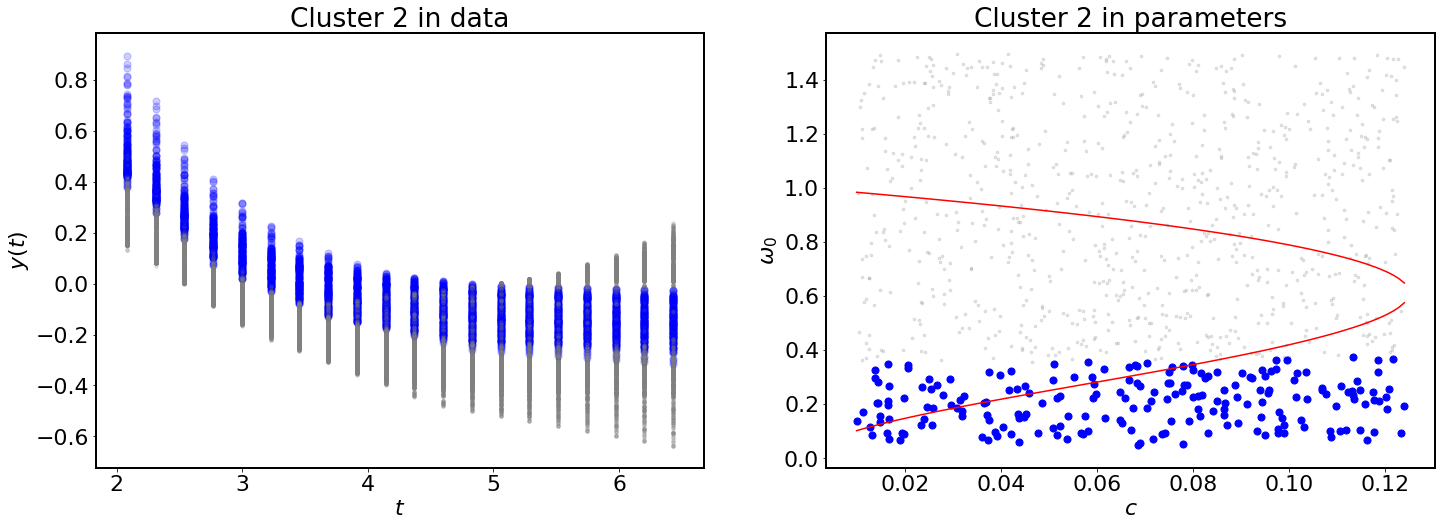

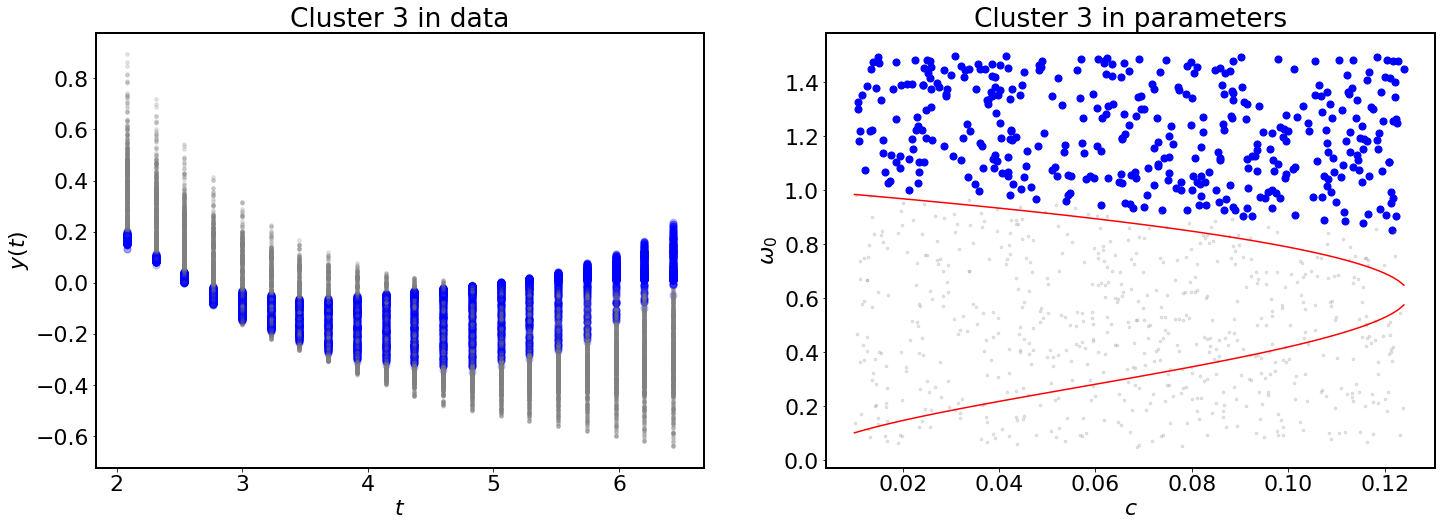

In [30]:
for j in range(learn.num_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
    ps = []
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            ps.append(params[i,0]/params[i,1])
            ax1.scatter(learn.clean_times, learn.clean_predictions[i,:], 50, c='b', marker='o', alpha=0.2)
        else:
            ax1.scatter(learn.clean_times, learn.clean_predictions[i,:], 50, c='gray', marker='.', alpha=0.2)
    ax1.set(title='Cluster ' + str(j+1) + ' in data')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$y(t)$')
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            ax2.scatter(params[i,0], params[i,1], 50, c='blue', marker='o')
        else:
            ax2.scatter(params[i,0], params[i,1], 30, c='gray', marker='.', alpha=0.2)
    ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
    ax2.set_ylabel('$\omega_0$')
    ax2.set_xlabel('$c$')
    xs = np.linspace(param_range[0,0], param_range[0,1], 100)
    ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
    ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
    ax2.plot(xs, ys1, 'r-')
    ax2.plot(xs, ys2, 'r-')
    fig.tight_layout

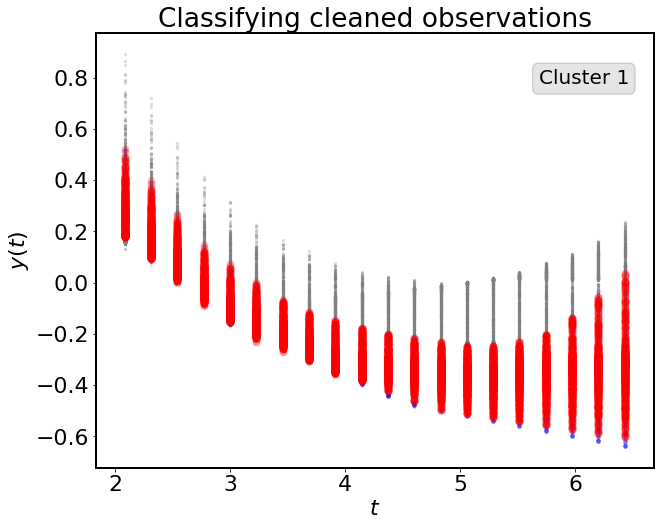

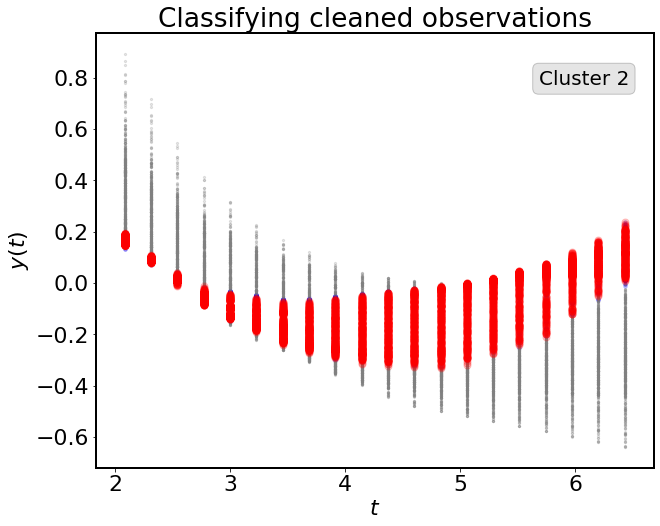

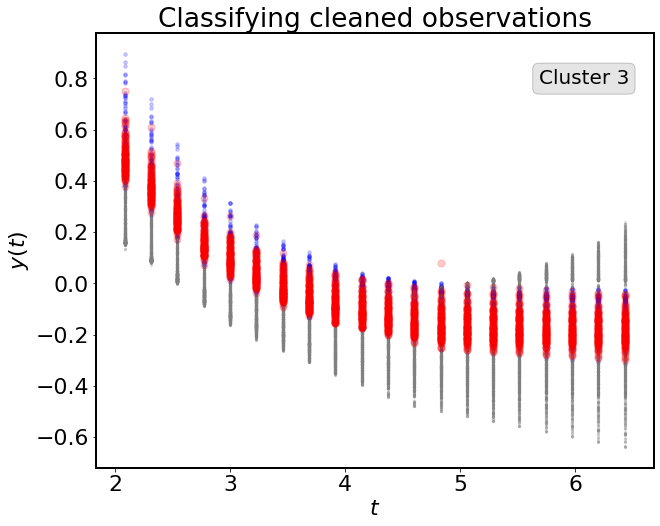

In [27]:
for j in range(learn.num_clusters):
    fig = plt.figure(figsize=(10,8))
    ps = []
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            ps.append(params[i,0]/params[i,1])
            plt.scatter(learn.clean_times, learn.clean_predictions[i,:], 50, c='b', marker='.', alpha=0.2)
        else:
            plt.scatter(learn.clean_times, learn.clean_predictions[i,:], 20, c='gray', marker='.', alpha=0.2)
    for i in range(num_obs):        
        if learn.obs_labels[i] == j:
            plt.scatter(learn.clean_times, learn.clean_obs[i, :], 50, c='r', marker='o', alpha=0.2)
    plt.title('Classifying cleaned observations')
    plt.xlabel('$t$')
    plt.ylabel('$y(t)$')
    bottom, top = plt.gca().get_ylim()
    left, right = plt.gca().get_xlim()
    props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
    plt.text(right-1, top-0.2, 
             'Cluster ' + str(j+1), 
             {'color': 'k', 'fontsize': 20},
             bbox=props)
    plt.text
    fig.tight_layout

In [10]:
# # Plot clusters of predicted time series
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,2.5), 
#                                         gridspec_kw={'width_ratios': [3,1,1]}) 
#     ps = []
#     ps2 = []
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             a = params[i, 0]
#             b = params[i, 1]
#             b1 = sqrt((1.0-sqrt(1.-8.*a)-2.*a)/2.0)
#             b2 = sqrt((1.0+sqrt(1.-8.*a)-2.*a)/2.0)
#             ps.append(b/b1)
#             ps2.append(b/b2)
#             ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
#     ax1.set(title='Cluster ' + str(j))
#     xs = np.linspace(0.0, 5.0, 100)
#     ax2.plot(xs, GKDE(ps)(xs))
#     ax2.axvline(1.0, color='r')
#     ax2.set(xlabel=r'$b/b_1$', title='Param. Distrib.')
#     xs2 = np.linspace(0.0, 2.0, 100)
#     ax3.plot(xs2, GKDE(ps2)(xs2))
#     ax3.axvline(1.0, color='r')
#     ax3.set(xlabel=r'$b/b_2$', title='Param. Distrib.')

In [11]:
# # Plot oberved and predicted clusters
# for j in range(learn.num_clusters):
#     plt.figure()
#     cluster_num = j
#     for i in range(num_samples):
#         if learn.predict_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
#     for i in range(num_obs):
#         if learn.obs_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [12]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=2)

2 principal components explain 99.1169% of variance for cluster 0 with {'kernel': 'linear'}
2 principal components explain 54.0712% of variance for cluster 0 with {'kernel': 'rbf'}
2 principal components explain 93.8615% of variance for cluster 0 with {'kernel': 'sigmoid'}
2 principal components explain 78.8929% of variance for cluster 0 with {'kernel': 'poly'}
2 principal components explain 98.3701% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'linear'}
2 principal components explain 99.1169% of variance.
2 principal components explain 95.9441% of variance for cluster 1 with {'kernel': 'linear'}
2 principal components explain 64.1657% of variance for cluster 1 with {'kernel': 'rbf'}
2 principal components explain 96.5000% of variance for cluster 1 with {'kernel': 'sigmoid'}
2 principal components explain 81.4614% of variance for cluster 1 with {'kernel': 'poly'}
2 principal components explain 93.4610% of variance for cluster 1 with {'ker

In [13]:
%reset -f out

def plot_gap(all_eig_vals, n, cluster):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    #Plotting until maximum number of knots
    eig_vals = all_eig_vals[cluster].lambdas_[0:10]
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals/np.sum(eig_vals)*100, Marker='.', MarkerSize=20, linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'k--')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n+1]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'r--')
    plt.text(n+1, eig_vals[n]/np.sum(eig_vals)*150, 
             r'%2.3f' %(np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100) + '% of variation explained by first ' + '%1d' %(n+1) + ' PCs.', 
                                                               {'color': 'k', 'fontsize': 20})
    plt.text(n+2, eig_vals[n+1]/np.sum(eig_vals)*150, 
             r'Order of magnitude of gap is %4.2f.' %(np.log10(eig_vals[n])-np.log10(eig_vals[n+1])), 
                                                               {'color': 'r', 'fontsize': 20})
    s = 'Determining QoI for cluster #%1d' %(cluster+1)
    plt.title(s)
    plt.xlabel('Principal Component #')
    plt.ylabel('% of Variation')
    plt.xlim([0.1, np.size(eig_vals)+1])
    plt.ylim([0,500])


wd.interact(plot_gap, all_eig_vals=wd.fixed(learn.kpcas),
            n = wd.IntSlider(value=0, min=0, max=5),
            cluster = wd.IntSlider(value=0, min=0, max=learn.num_clusters-1))

Flushing output cache (3 entries)


interactive(children=(IntSlider(value=0, description='n', max=5), IntSlider(value=0, description='cluster', ma…

<function __main__.plot_gap(all_eig_vals, n, cluster)>

In [14]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals = learn.compute_r()

Diagnostic for clusters [sample average of ratios in each cluster]: [1.0527606477445863, 0.941960158318298, 1.0773420135932936]


In [15]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
ic_marginals = []
true_param_marginals = []
true_ic_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        
##for i in range(ics.shape[1]):
#    true_ic_marginals.append(GKDE(ics_obs[:,i]))
#    ic_marginals.append([])
#    for j in range(learn.num_clusters):
#        ic_marginals[i].append(GKDE(ics[lam_ptr[j], i], weights=learn.r[j]))

In [16]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

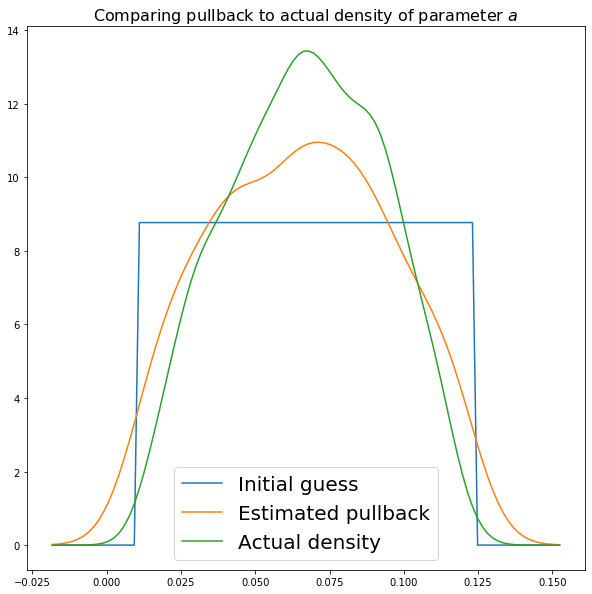

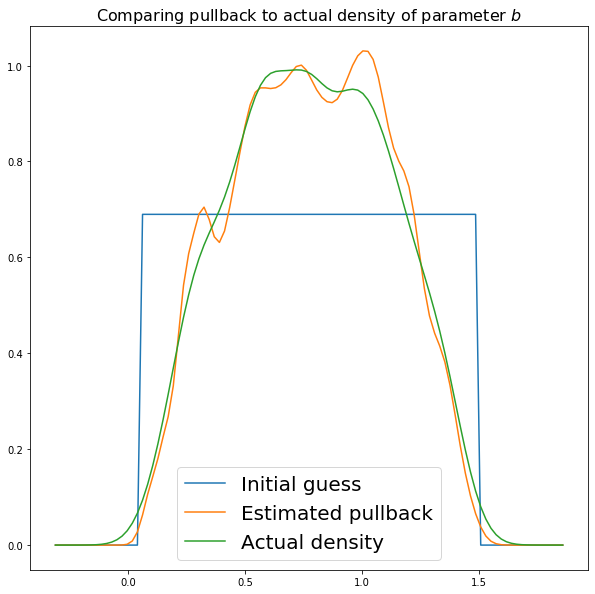

In [17]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

In [18]:
# # Plot predicted marginal densities for initial conditions.

# for i in range(ics.shape[1]):
#     fig = plt.figure(figsize=(10,10))
#     fig.clear()
#     x_min = min(min(ics[:, i]), min(ics_obs[:, i]))
#     x_max = max(max(ics[:, i]), max(ics_obs[:, i]))
#     delt = 0.25*(x_max - x_min)
#     x = np.linspace(x_min-delt, x_max+delt, 100)
#     plt.plot(x, unif_dist(x, ic_range[i, :]),
#          label = 'Initial guess')
#     mar = np.zeros(x.shape)
#     for j in range(learn.num_clusters):
#         mar += ic_marginals[i][j](x) * cluster_weights[j]
#     plt.plot(x, mar, label = 'Estimated pullback')
#     plt.plot(x, true_ic_marginals[i](x), label = 'Actual density')
#     plt.title('Comparing pullback to actual density of initial condition ' + ic_labels[i], fontsize=16)
#     plt.legend(fontsize=20)

### Compute TV metric between densities

In [19]:
import scipy.integrate.quadrature as quad

In [20]:
def param_init_error(x):
    return np.abs(unif_dist(x,param_range[param_num, :])-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_init_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.37035336003296876, 6.161828824957638e-10)
(0.357677869838007, 1.3475679461194545e-08)


In [21]:
def param_update_KDE_error(x):
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[param_num][j](x) * cluster_weights[j]
    return np.abs(mar-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_update_KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.16925918974074186, 1.270774024897392e-08)
(0.05781182248590809, 1.3410671524660689e-08)


In [22]:
from scipy.stats import beta 

In [23]:
def KDE_error(x):
    true_beta = beta(a=true_a, b=true_b,loc=param_range[i,0],scale=param_range[i,1]-param_range[i,0])
    return np.abs(true_beta.pdf(x)-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.0429762056116479, 9.748510471085936e-10)
(0.03612121761942654, 6.252186081356914e-09)
